In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.utils.data
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler
import time

In [2]:
ti = time.time()

In [3]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Modified by M. Romero.
    Original: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [4]:
mpl.rc("font", size=20)

#### Carga del dataset

In [5]:
digits = load_digits()
targets = digits.target
data = digits.data
classes = digits.target_names

#### Division train-val-test

In [6]:
# train-validation-test split
nsamples, ndim = data.shape
nlabels = len(classes)
indexes = np.arange(nsamples)
train_idx, test_idx = train_test_split(indexes, test_size=0.2)
train_idx, val_idx = train_test_split(train_idx, test_size=0.1/0.8)

print("train {:.0f} %".format(len(train_idx)/nsamples*100))
print("val {:.0f} %".format(len(val_idx)/nsamples*100))
print("test {:.0f} %".format(len(test_idx)/nsamples*100))

x_train = data[train_idx]
x_val = data[val_idx]
x_test = data[test_idx]

y_train = targets[train_idx]
y_val = targets[val_idx]
y_test = targets[test_idx]

train 70 %
val 10 %
test 20 %


#### Normalizacion de datos

In [7]:
#scaler = StandardScaler() # (x - mu)/std, (mu, std) = (0, 1)
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

#### Declaracion de tensores y dispositivo de trabajo

In [8]:
cuda = False
device = torch.device("cuda:0" if cuda and torch.cuda.is_available() else "cpu")
print(device)

cpu


In [9]:
x_train = torch.tensor(x_train, device=device, dtype=torch.float)
x_val = torch.tensor(x_val, device=device, dtype=torch.float)
x_test = torch.tensor(x_test, device=device, dtype=torch.float)

y_train = torch.tensor(y_train, device=device, dtype=torch.long) # ojo que al utilizar CrossEntropyLoss 
y_val = torch.tensor(y_val, device=device, dtype=torch.long)     # la entrada debe ser tipo long
y_test = torch.tensor(y_test, device=device, dtype=torch.long)

#### Declaracion de dataset

In [10]:
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

#### Construccion de red neuronal

In [11]:
class MLP(torch.nn.Module):
    def __init__(self, ninput, nhidden, nout, bn=False, do=False):
        super(MLP, self).__init__()
        layers = []
        layers.append(torch.nn.Linear(ninput, nhidden))
        layers.append(torch.nn.BatchNorm1d(nhidden)) if bn else 0
        layers.append(torch.nn.Dropout(0.5)) if do else 0
        layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Linear(nhidden, nout))
        self.mlp = torch.nn.Sequential(*layers)


    def forward(self, x):
        return self.mlp(x)
    
    
class AE(torch.nn.Module):
    def __init__(self, nin, nl, bn=False, do=False):
        super(AE, self).__init__()
        self.enc1 = torch.nn.Linear(nin, 32)
        self.enc2 = torch.nn.Linear(32, nl)
        self.dec1 = torch.nn.Linear(32, nin)
        self.dec2 = torch.nn.Linear(nl, 32)
        self.relu = torch.nn.ReLU()
        self.sig = torch.nn.Sigmoid()
    
    def encode(self, x):
        e1 = self.relu(self.enc1(x))
        return self.enc2(e1)
    
    def decode(self, u):
        d1 = self.relu(self.dec2(u))
        return self.sig(self.dec1(d1))
        
    def forward(self, x):
        l = self.encode(x)
        r = self.decode(l)
        return l, r

#### Decalaracion de hiper parametros

In [22]:
lr = 2e-4
wd = 0.
bs = 10
neurons = 100
epochs = 200

#### Funcion de perdida

In [23]:
cel = torch.nn.CrossEntropyLoss()
bcel = torch.nn.BCELoss()
msel = torch.nn.MSELoss()

#### Declaracion de dataloader

In [24]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=True)

#### Funcion de entrenamiento

In [25]:
def train_my_model(epochs, model, optimizer, loss_function, trainloader, valloader, testloader):
    losses = np.zeros((epochs, 3))
    best_val_loss = np.inf
    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0
        test_loss = 0
        model.train()
        for i, batch in enumerate(trainloader):
            x_in, y_in = batch
            _, x_out = model(x_in)
            loss = loss_function(x_out, x_in)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= i + 1
        model.eval()
        with torch.no_grad():
            for i, batch in enumerate(valloader):
                x_in, y_in = batch
                _, x_out = model(x_in)
                loss = loss_function(x_out, x_in)
                val_loss += loss.item()
            val_loss /= i + 1
            for i, batch in enumerate(testloader):
                x_in, y_in = batch
                _, x_out = model(x_in)
                loss = loss_function(x_out, x_in)
                test_loss += loss.item()
            test_loss /= i + 1
        losses[epoch] = [train_loss, val_loss, test_loss]
        print("Epoch {} Train loss {:.3f} Val loss {:.3f} Test loss {:.3f}".format(epoch, train_loss, val_loss, test_loss))
        if val_loss < best_val_loss:
            print("Saving")
            torch.save(model.state_dict(), "models/ae.pth")
            best_val_loss = val_loss
    return losses


def plot_my_loss(loss, title, ylabel="mean cross entropy"):
    plt.figure(figsize=(20, 5))
    plt.plot(loss[:, 0], color="navy", label="train")
    plt.plot(loss[:, 1], color="green", label="val")
    plt.plot(loss[:, 2], color="red", label="test")
    plt.xlabel("epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.ylim([0, 2])
    return


def eval_my_model(model, test_data):
    model.eval()
    with torch.no_grad():
        xl, x_out = model(test_data)
    return xl.cpu().numpy(), x_out.cpu().numpy()

In [26]:
model_bce = AE(x_train.shape[1], 2).to(device)
optimizer_bce = torch.optim.Adamax(model_bce.parameters(), lr=lr, weight_decay=wd)
loss_bce = train_my_model(epochs, model_bce, optimizer_bce, bcel, train_loader, val_loader, test_loader)
model_bce.load_state_dict(torch.load("models/ae.pth"))

Epoch 0 Train loss 0.686 Val loss 0.673 Test loss 0.673
Saving
Epoch 1 Train loss 0.648 Val loss 0.615 Test loss 0.614
Saving
Epoch 2 Train loss 0.572 Val loss 0.528 Test loss 0.526
Saving
Epoch 3 Train loss 0.497 Val loss 0.479 Test loss 0.479
Saving
Epoch 4 Train loss 0.488 Val loss 0.493 Test loss 0.496
Epoch 5 Train loss 0.488 Val loss 0.472 Test loss 0.476
Saving
Epoch 6 Train loss 0.458 Val loss 0.447 Test loss 0.451
Saving
Epoch 7 Train loss 0.447 Val loss 0.449 Test loss 0.450
Epoch 8 Train loss 0.453 Val loss 0.456 Test loss 0.456
Epoch 9 Train loss 0.458 Val loss 0.458 Test loss 0.457
Epoch 10 Train loss 0.455 Val loss 0.450 Test loss 0.450
Epoch 11 Train loss 0.447 Val loss 0.443 Test loss 0.443
Saving
Epoch 12 Train loss 0.439 Val loss 0.435 Test loss 0.434
Saving
Epoch 13 Train loss 0.429 Val loss 0.428 Test loss 0.426
Saving
Epoch 14 Train loss 0.425 Val loss 0.427 Test loss 0.425
Saving
Epoch 15 Train loss 0.422 Val loss 0.425 Test loss 0.424
Saving
Epoch 16 Train loss 0

Epoch 142 Train loss 0.425 Val loss 0.426 Test loss 0.429
Epoch 143 Train loss 0.427 Val loss 0.425 Test loss 0.430
Epoch 144 Train loss 0.427 Val loss 0.423 Test loss 0.427
Epoch 145 Train loss 0.424 Val loss 0.421 Test loss 0.424
Epoch 146 Train loss 0.421 Val loss 0.421 Test loss 0.422
Epoch 147 Train loss 0.423 Val loss 0.421 Test loss 0.422
Epoch 148 Train loss 0.422 Val loss 0.420 Test loss 0.420
Epoch 149 Train loss 0.421 Val loss 0.421 Test loss 0.422
Epoch 150 Train loss 0.422 Val loss 0.422 Test loss 0.423
Epoch 151 Train loss 0.423 Val loss 0.424 Test loss 0.426
Epoch 152 Train loss 0.425 Val loss 0.425 Test loss 0.428
Epoch 153 Train loss 0.423 Val loss 0.423 Test loss 0.425
Epoch 154 Train loss 0.421 Val loss 0.422 Test loss 0.423
Epoch 155 Train loss 0.421 Val loss 0.421 Test loss 0.424
Epoch 156 Train loss 0.423 Val loss 0.422 Test loss 0.425
Epoch 157 Train loss 0.423 Val loss 0.424 Test loss 0.426
Epoch 158 Train loss 0.422 Val loss 0.424 Test loss 0.428
Epoch 159 Trai

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [27]:
model_mse = AE(x_train.shape[1], 2).to(device)
optimizer_mse = torch.optim.Adamax(model_mse.parameters(), lr=lr, weight_decay=wd)
loss_mse = train_my_model(epochs, model_mse, optimizer_mse, msel, train_loader, val_loader, test_loader)
model_mse.load_state_dict(torch.load("models/ae.pth"))

Epoch 0 Train loss 0.169 Val loss 0.156 Test loss 0.156
Saving
Epoch 1 Train loss 0.137 Val loss 0.118 Test loss 0.118
Saving
Epoch 2 Train loss 0.100 Val loss 0.090 Test loss 0.090
Saving
Epoch 3 Train loss 0.087 Val loss 0.088 Test loss 0.087
Saving
Epoch 4 Train loss 0.088 Val loss 0.092 Test loss 0.091
Epoch 5 Train loss 0.091 Val loss 0.094 Test loss 0.092
Epoch 6 Train loss 0.095 Val loss 0.094 Test loss 0.093
Epoch 7 Train loss 0.097 Val loss 0.100 Test loss 0.101
Epoch 8 Train loss 0.094 Val loss 0.097 Test loss 0.096
Epoch 9 Train loss 0.098 Val loss 0.095 Test loss 0.095
Epoch 10 Train loss 0.092 Val loss 0.093 Test loss 0.094
Epoch 11 Train loss 0.092 Val loss 0.090 Test loss 0.090
Epoch 12 Train loss 0.086 Val loss 0.084 Test loss 0.084
Saving
Epoch 13 Train loss 0.082 Val loss 0.082 Test loss 0.082
Saving
Epoch 14 Train loss 0.080 Val loss 0.080 Test loss 0.079
Saving
Epoch 15 Train loss 0.078 Val loss 0.079 Test loss 0.078
Saving
Epoch 16 Train loss 0.078 Val loss 0.080 T

Epoch 141 Train loss 0.068 Val loss 0.070 Test loss 0.069
Epoch 142 Train loss 0.068 Val loss 0.070 Test loss 0.069
Epoch 143 Train loss 0.070 Val loss 0.074 Test loss 0.075
Epoch 144 Train loss 0.071 Val loss 0.071 Test loss 0.071
Epoch 145 Train loss 0.069 Val loss 0.071 Test loss 0.070
Epoch 146 Train loss 0.068 Val loss 0.070 Test loss 0.070
Epoch 147 Train loss 0.070 Val loss 0.072 Test loss 0.073
Epoch 148 Train loss 0.073 Val loss 0.074 Test loss 0.076
Epoch 149 Train loss 0.076 Val loss 0.075 Test loss 0.077
Epoch 150 Train loss 0.075 Val loss 0.073 Test loss 0.075
Epoch 151 Train loss 0.073 Val loss 0.071 Test loss 0.072
Epoch 152 Train loss 0.071 Val loss 0.071 Test loss 0.071
Epoch 153 Train loss 0.070 Val loss 0.071 Test loss 0.071
Epoch 154 Train loss 0.070 Val loss 0.072 Test loss 0.071
Epoch 155 Train loss 0.070 Val loss 0.072 Test loss 0.071
Epoch 156 Train loss 0.071 Val loss 0.073 Test loss 0.072
Epoch 157 Train loss 0.074 Val loss 0.074 Test loss 0.074
Epoch 158 Trai

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [28]:
xl_bce, x_out_bce = eval_my_model(model_bce, x_test)

In [29]:
xl_mse, x_out_mse = eval_my_model(model_mse, x_test)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

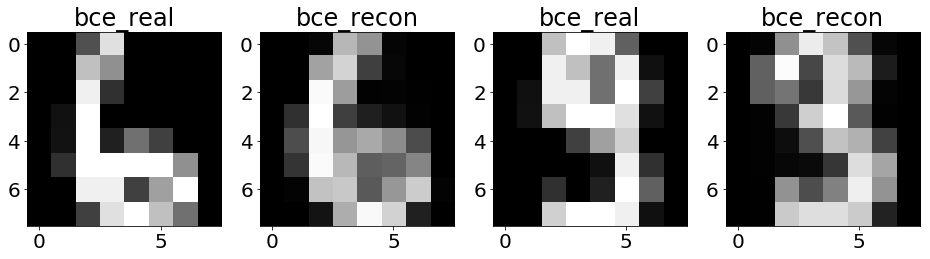

<Figure size 432x288 with 0 Axes>

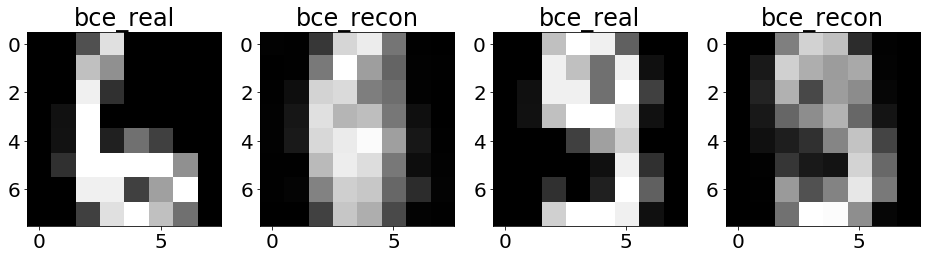

In [39]:
plt.gray()
plt.figure()
i1 = np.random.randint(0, x_test.shape[0])
i2 = np.random.randint(0, x_test.shape[0])
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(4*4, 4))
ax[0].set_title("bce_real")
ax[0].imshow(x_test[i1].cpu().numpy().reshape((8, 8)))
ax[1].set_title("bce_recon")
ax[1].imshow(x_out_bce[i1].reshape((8, 8)))
ax[2].set_title("bce_real")
ax[2].imshow(x_test[i2].cpu().numpy().reshape((8, 8)))
ax[3].set_title("bce_recon")
ax[3].imshow(x_out_bce[i2].reshape((8, 8)))
plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(4*4, 4))
ax[0].set_title("bce_real")
ax[0].imshow(x_test[i1].cpu().numpy().reshape((8, 8)))
ax[1].set_title("bce_recon")
ax[1].imshow(x_out_mse[i1].reshape((8, 8)))
ax[2].set_title("bce_real")
ax[2].imshow(x_test[i2].cpu().numpy().reshape((8, 8)))
ax[3].set_title("bce_recon")
ax[3].imshow(x_out_mse[i2].reshape((8, 8)))